In [ ]:
! pip install tkcalendar
! pip install pandas-datareader
! pip install yfinance
! pip install mplfinance

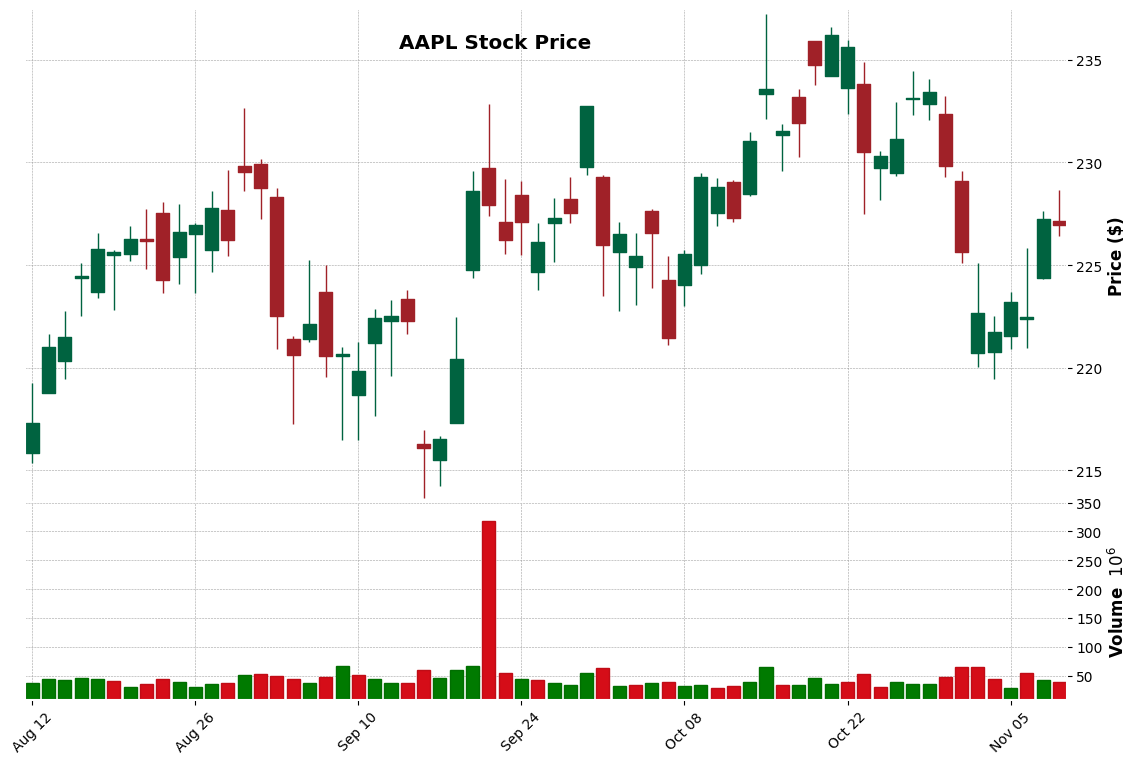

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
from tkcalendar import DateEntry
import datetime as dt
from typing import Tuple
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

class StockVisualizerApp:
    def __init__(self, root: tk.Tk):
        self.root = root
        self.root.title("Stock Market Visualizer v1.0")
        self.root.geometry("400x600")  # Increased height for new controls
        self.root.configure(padx=20, pady=20)
        
        # Calculate date limits
        self.max_date = dt.datetime.now().date()
        self.min_date = self.max_date - dt.timedelta(days=15*365)
        
        self._create_widgets()
        self._setup_layout()

    def _create_widgets(self):
        """Create all GUI widgets"""
        # Date selection frames
        self.date_frame = ttk.LabelFrame(self.root, text="Date Range", padding="10")
        
        # Quick date range selection
        self.quick_range_frame = ttk.Frame(self.date_frame)
        self.range_var = tk.StringVar(value="custom")
        
        self.radio_current_month = ttk.Radiobutton(
            self.quick_range_frame,
            text="Current Month",
            variable=self.range_var,
            value="1m",
            command=self.update_date_range
        )
        
        self.radio_3_months = ttk.Radiobutton(
            self.quick_range_frame,
            text="Last 3 Months",
            variable=self.range_var,
            value="3m",
            command=self.update_date_range
        )
        
        self.radio_6_months = ttk.Radiobutton(
            self.quick_range_frame,
            text="Last 6 Months",
            variable=self.range_var,
            value="6m",
            command=self.update_date_range
        )
        
        self.radio_1_year = ttk.Radiobutton(
            self.quick_range_frame,
            text="Last 1 Year",
            variable=self.range_var,
            value="1y",
            command=self.update_date_range
        )
        
        self.radio_custom = ttk.Radiobutton(
            self.quick_range_frame,
            text="Custom Range",
            variable=self.range_var,
            value="custom",
            command=self.update_date_range
        )
        
        # Calendar entries
        self.from_frame = ttk.Frame(self.date_frame)
        self.label_from = ttk.Label(self.from_frame, text="From:")
        self.cal_from = DateEntry(
            self.from_frame,
            width=15,
            year=max(2023, self.min_date.year),
            month=1,
            day=1,
            mindate=self.min_date,
            maxdate=self.max_date
        )
        
        self.to_frame = ttk.Frame(self.date_frame)
        self.label_to = ttk.Label(self.to_frame, text="To:")
        self.cal_to = DateEntry(
            self.to_frame,
            width=15,
            mindate=self.min_date,
            maxdate=self.max_date
        )
        
        # Add date range label
        self.date_range_label = ttk.Label(
            self.date_frame,
            text=f"Valid date range: {self.min_date.strftime('%Y-%m-%d')} to {self.max_date.strftime('%Y-%m-%d')}",
            wraplength=350
        )
        
        # Ticker input
        self.ticker_frame = ttk.LabelFrame(self.root, text="Stock Symbol", padding="10")
        self.text_ticker = ttk.Entry(self.ticker_frame)
        
        # Chart options
        self.options_frame = ttk.LabelFrame(self.root, text="Chart Options", padding="10")
        self.theme_var = tk.StringVar(value="light")
        self.dark_theme = ttk.Radiobutton(
            self.options_frame,
            text="Dark Theme",
            variable=self.theme_var,
            value="dark"
        )
        self.light_theme = ttk.Radiobutton(
            self.options_frame,
            text="Light Theme",
            variable=self.theme_var,
            value="light"
        )
        
        # Buttons
        self.button_frame = ttk.Frame(self.root)
        self.btn_visualize = ttk.Button(
            self.button_frame,
            text="Visualize",
            command=self.visualize
        )
        self.btn_clear = ttk.Button(
            self.button_frame,
            text="Clear",
            command=self.clear_form
        )

        # Bind date validation
        self.cal_from.bind("<<DateEntrySelected>>", self.on_date_change)
        self.cal_to.bind("<<DateEntrySelected>>", self.on_date_change)

    def _setup_layout(self):
        """Setup the layout using pack geometry manager"""
        self.date_frame.pack(fill="x", padx=5, pady=5)
        
        # Quick range selection layout
        self.quick_range_frame.pack(fill="x", pady=5)
        self.radio_current_month.pack(anchor="w", padx=5, pady=2)
        self.radio_3_months.pack(anchor="w", padx=5, pady=2)
        self.radio_6_months.pack(anchor="w", padx=5, pady=2)
        self.radio_1_year.pack(anchor="w", padx=5, pady=2)
        self.radio_custom.pack(anchor="w", padx=5, pady=2)
        
        # Calendar entries layout
        self.from_frame.pack(fill="x", pady=2)
        self.label_from.pack(side="left")
        self.cal_from.pack(side="right")
        
        self.to_frame.pack(fill="x", pady=2)
        self.label_to.pack(side="left")
        self.cal_to.pack(side="right")
        
        self.date_range_label.pack(fill="x", pady=(5, 0))
        
        self.ticker_frame.pack(fill="x", padx=5, pady=5)
        self.text_ticker.pack(fill="x", padx=5)
        
        self.options_frame.pack(fill="x", padx=5, pady=5)
        self.dark_theme.pack(side="left", padx=10)
        self.light_theme.pack(side="left", padx=10)
        
        self.button_frame.pack(fill="x", padx=5, pady=10)
        self.btn_visualize.pack(side="left", padx=5)
        self.btn_clear.pack(side="right", padx=5)

    def update_date_range(self):
        """Update date range based on radio selection"""
        range_type = self.range_var.get()
        end_date = dt.datetime.now().date()
        
        if range_type == "1m":
            start_date = end_date.replace(day=1)
        elif range_type == "3m":
            start_date = end_date - dt.timedelta(days=90)
        elif range_type == "6m":
            start_date = end_date - dt.timedelta(days=180)
        elif range_type == "1y":
            start_date = end_date - dt.timedelta(days=365)
        else:  # custom
            return  # Don't update dates for custom selection
        
        self.cal_from.set_date(start_date)
        self.cal_to.set_date(end_date)

    def on_date_change(self, event=None):
        """Handle date changes"""
        self.validate_dates()
        self.range_var.set("custom")  # Switch to custom when dates are manually changed

    def validate_dates(self, event=None):
        """Validate and adjust dates if necessary"""
        from_date = self.cal_from.get_date()
        to_date = self.cal_to.get_date()
        
        # Ensure dates are within valid range
        if from_date < self.min_date:
            self.cal_from.set_date(self.min_date)
            messagebox.showwarning("Invalid Date", "Start date cannot be earlier than 15 years ago.")
        
        if to_date > self.max_date:
            self.cal_to.set_date(self.max_date)
            messagebox.showwarning("Invalid Date", "End date cannot be in the future.")
        
        # Ensure from_date is not after to_date
        if from_date > to_date:
            self.cal_from.set_date(to_date)
            messagebox.showwarning("Invalid Date Range", "Start date cannot be after end date.")

    @staticmethod
    def get_stock_data(ticker: str, start: dt.datetime, end: dt.datetime) -> Tuple[bool, any]:
        """Fetch stock data with error handling"""
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(start=start, end=end, interval="1d")
            if data.empty:
                return False, "No data available for this ticker symbol"
            return True, data
        except Exception as e:
            return False, f"Error fetching data: {str(e)}"

    def visualize(self):
        """Create and display the stock visualization"""
        ticker = self.text_ticker.get().strip().upper()
        if not ticker:
            messagebox.showerror("Error", "Please enter a ticker symbol")
            return

        from_date = self.cal_from.get_date()
        to_date = self.cal_to.get_date()
        
        if from_date < self.min_date or to_date > self.max_date:
            messagebox.showerror("Error", "Selected dates are outside the valid range")
            return
            
        start = dt.datetime(from_date.year, from_date.month, from_date.day)
        end = dt.datetime(to_date.year, to_date.month, to_date.day)

        # Validate dates
        if start >= end:
            messagebox.showerror("Error", "Start date must be before end date")
            return

        # Fetch data
        success, data = self.get_stock_data(ticker, start, end)
        if not success:
            messagebox.showerror("Error", data)
            return

        # Create and display the plot
        style = 'charles' if self.theme_var.get() == "light" else "nightclouds"
        
        mpf.plot(
            data,
            type='candle',
            style=style,
            title=f'\n{ticker} Stock Price\n',
            ylabel='Price ($)',
            volume=True,
            figsize=(12, 8),
            warn_too_much_data=10000,
            update_width_config=dict(
                candle_linewidth=1.0,
                candle_width=0.8,
                volume_linewidth=1.0,
                volume_width=0.8
            ),
            tight_layout=True,
            block=False
        )

    def clear_form(self):
        """Reset all form fields"""
        self.text_ticker.delete(0, tk.END)
        default_start = max(dt.datetime(2023, 1, 1).date(), self.min_date)
        self.cal_from.set_date(default_start)
        self.cal_to.set_date(self.max_date)
        self.theme_var.set("light")
        self.range_var.set("custom")

def main():
    root = tk.Tk()
    app = StockVisualizerApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()